In [2]:
# Project imports #
import pandas as pd
import numpy as np
import psycopg2 as pg2
import matplotlib.pyplot as plt
import json
import csv
import re
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from arch.unitroot import engle_granger
from datetime import datetime
import calendar
from calendar import monthrange
# Matplotlib settings #
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# Project overview
#### Objective: Create a daily labor demand index based on job ads to calculate total available jobs in Sweden for a given day between 2006-2020      
- In this project, only job ads from Arbetsförmedlingen (JobTechDev), the Swedish public employment service will be used. The dataset contains all job ads published on Arbetsförmedlingens job ads platform 'Platsbanken' between 2006-2020.
    
- Statistics from the [European Commission](https://wayback.archive-it.org/12090/20201012083437/https://ec.europa.eu/info/sites/info/files/european-semester_thematic-factsheet_public-employment-services_en_0.pdf) shows that the percentage of job seekers using public employment services in EU-countries is among the highest in Sweden, above 70%. Thus, the index may be a good complement to official statistics in measuring aggregate labor demand.
    
- Performance of the index will be evaluated through comparison to Sweden's official statistics concerning total available jobs i.e. labor demand.

#### Project outline
- Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
- Step 2: Inserting data into a PostgreSQL database and setting up a query
- Step 3: Visualization and discussion of results
- Step 4: Time series analysis
- Concluding remarks

<hr />

### Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
#### All job ads data used in this project is from [JobTechDev](https://jobtechdev.se/en/docs/apis/historical/), an initiative by the Swedish public employment service.
- The complete dataset is about 30.8 GB (unzipped) and files are in the JSON-format
- Dataset contains 32 differerent columns/vars, many of which are beyond the scope of the project, as such a selection will be extracted.

- Variables to be extracted for this project are the following:
    - **headline**: The ad headline.
    - **number_of_vacancies**: The number of advertised jobs for a given ad, a majority only advertise 1 job (5M out of 6.4M ads).
    - **publication_date**: Date the ad was published on Platsbanken, the job ad platform.
    - **application_deadline**: The last date to apply for the job.
    - **last_publication_date**: The last date the ad was public, used as substitutet for application_deadline for 2017 where application_deadline is missing.

In [2]:
total_valid = 0; total_errors = 0
for file in range(2006,2021):
    filename = f'/Users/Kevin/Desktop/project_dta/json_pb2006_2020/{file}.json'
    with open(filename) as f:
        ads = json.load(f)
        file_ads = []
        error_rows = 0
        
    # For 2017 application_deadline is null, last_publication_date used as a proxy, vars 99.8% equivalent #
    for ad in ads:
        # Removal of special characters using regex, events of \n causes errors in csv file #
        head_line = re.sub('[!,*)@#%(&$_?.^\\\\\n/]', '', str(ad['headline']))
        if file != 2017:
            try: 
        # Slicing of date variables is to ensure only dates of the format 'yyyy-mm-dd' are included, no time data needed #
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10]]
            except:
                error_rows += 1
                continue
        else:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10]]    
            except:
                error_rows += 1
                continue
                
        # Jobs ads with no vacancies (=0) or missing values (None) in dates or vacancies are removed using all() #
        if all(ad_select[1:]):
            file_ads.append(ad_select)
        else:
            error_rows += 1
            continue

    # We write the extracted data to a csv file for easy insertion into PostgreSQL #             
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/{file}.csv', mode='w', newline="") as file_writer:
        write = csv.writer(file_writer)
        for row in file_ads:
            write.writerow(row)
    print(f'valid ads for {file}: ' + str(len(file_ads)), ' | ', f'erroneous ads for {file}: ' + str(error_rows))
    total_valid += len(file_ads); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), '  |  ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2006: 213849  |  erroneous ads for 2006: 31378
valid ads for 2007: 265730  |  erroneous ads for 2007: 18375
valid ads for 2008: 248552  |  erroneous ads for 2008: 16671
valid ads for 2009: 180215  |  erroneous ads for 2009: 15909
valid ads for 2010: 268671  |  erroneous ads for 2010: 20583
valid ads for 2011: 343344  |  erroneous ads for 2011: 21344
valid ads for 2012: 356140  |  erroneous ads for 2012: 23218
valid ads for 2013: 365361  |  erroneous ads for 2013: 24692
valid ads for 2014: 428760  |  erroneous ads for 2014: 23225
valid ads for 2015: 593441  |  erroneous ads for 2015: 20072
valid ads for 2016: 703170  |  erroneous ads for 2016: 14876
valid ads for 2017: 704424  |  erroneous ads for 2017: 10867
valid ads for 2018: 682969  |  erroneous ads for 2018: 0
valid ads for 2019: 640257  |  erroneous ads for 2019: 0
valid ads for 2020: 445120  |  erroneous ads for 2020: 79


total valid ads: 6440003   |   total erroneous ads: 241289


- As seen in the output above, our dataset consists of 6 440 003 ads/rows. We also find that 241 289 ads/rows did not meet the project requirements and were filtered out.

### Step 2: Inserting data into a postgreSQL database and setting up relevant query
 - For efficient analysis and storage of the dataset we import the data into PostgreSQL.

In [3]:
# DB created in pgAdmin4 GUI, login and connect cursor #
conn = pg2.connect(database='job_ads', user='postgres', password='**********')
cur = conn.cursor()

In [4]:
# Table creation # 
# If data cleaning method in previous step missed any invalid ads, NOT NULL ascertains that no invalid ads are included #
cur.execute("""
CREATE TABLE historic_ads(
    ad_id SERIAL PRIMARY KEY,
    headline VARCHAR,
    number_of_vacancies INTEGER NOT NULL,
    publication_date DATE NOT NULL,
    application_deadline DATE NOT NULL);""")
conn.commit()

In [5]:
# Importing csv files into PostgreSQL #
for file in range(2006, 2021):
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/{file}.csv', 'r') as csv_file:
        cur.copy_from(csv_file, 'historic_ads', sep=',', columns=('headline', 'number_of_vacancies', 'publication_date', 'application_deadline'))
    conn.commit()

- In the cell below we check, for each day between 2006-2020, how many ads were active for a given day and sum the vacancies of these ads. This is done by looping through each day in the time interval and checking how many ads have the given day (e.g. 2006-05-22) in between it's publication and deadline date (e.g. pub 2006-04-27 --  dead 2006-05-23). For all active ads, vacancies are summed and appended to a list as results.

In [6]:
vacancies_per_day = []
for year in range(2006, 2021):
    for month in range(1,13): 
        # cal.monthrange correctly sets the last day for each month #
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
SELECT SUM(number_of_vacancies) FROM historic_ads WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline;
""")
            ads_day = [f'{year}-{month}-{day}', cur.fetchone()[0]]
            vacancies_per_day.append(ads_day)
# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/results.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    for row in vacancies_per_day:
        write.writerow(row)

### Step 3: Visualization and discussion of results
#### The comparison data from Statistics Sweden and can be found [here](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KVLedigajobbSektor/).
- The comparison data is based on survey results that are published quarterly by Sweden's statistical agency, Statistics Sweden (SCB).
- The selected comparison data is between Q1 2006 - Q3 2020 which coincides with our job ads data.
- In addition to our two indices, we will also use quarterly constant-price [GDP](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__NR__NR0103__NR0103A/NR0103ENS2010T01Kv/) data supplied by Statistics Sweden.

In [3]:
# Importing results and comparison csv files and adding appropriate datetime indexing #
results = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/results.csv', names=['date', 'ad_vacancies'])
results = results.set_index(pd.to_datetime(results['date'])).drop('date', axis=1)
comparison = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/lediga_jobb.csv').drop('quarter', axis=1)
comparison = comparison.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q'))
gdp = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/gdp.csv', sep=';')
gdp = gdp.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q')).drop('date', axis=1)

In [4]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2006','2022', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2006, 2022)

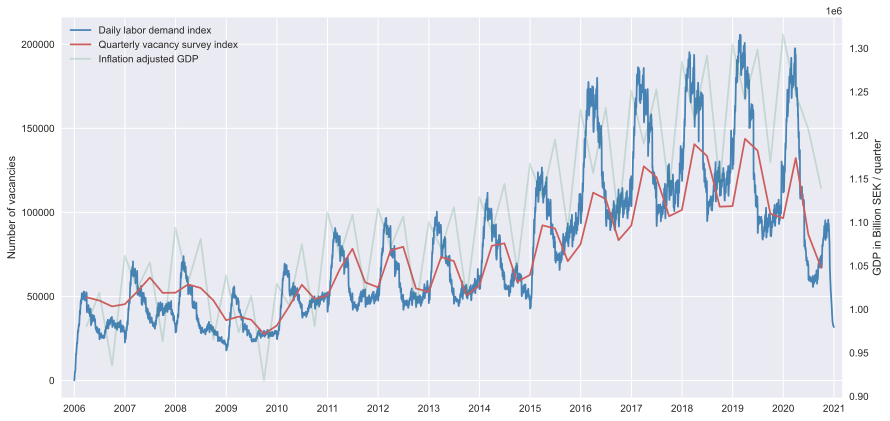

In [35]:
plt.figure(figsize=(14,7))
x = plt.plot(results.index, results, label='Daily labor demand index', color='steelblue')
y = plt.plot(comparison.index, comparison, label='Quarterly vacancy survey index', color='indianred')
plt.ylabel('Number of vacancies')
plt.twinx()
plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
z = plt.plot(gdp.index, gdp, label='Inflation adjusted GDP', color='seagreen', alpha=0.2)
plt.ylabel('GDP in Billion SEK / quarter')
plt.grid(b=None)
lines = x+y+z; labels = [i.get_label() for i in lines]
plt.legend(lines, labels)
plt.show()

### Discussion
- In the graph above we observe the daily labor demand index plotted together with Statistics Sweden's quarterly survey. Visually, the two time series show a clear co-movement. Thus, it is expect that much of the variation in the official survey could be explained by the daily index.
- Additionally, we have also plotted Swedens quarterly constant-price GDP (reference year 2019) which clearly moves together with our two indices. The spikes in GDP are followed by increases in the daily labor demand index. This could be an effect of the delay between increased labor demand (from increased production) and the start of actual recruitment i.e. job ads being posted.
- It seems that changes in labor demand in the daily index based on job ads happen about one quarter before the change is seen in the quarterly survey index.
- Given that the daily labor demand index is behaving as a higher-frequency version of Statistics Sweden's quarterly survey, it could potentially be used as a cheap and more timely complement.

<hr />

### Step 4: Time series analysis
- In this step we will analyze our indices statistically. We will start by decomposing our time series into trend, seasonal and residual components. After this follows regression analysis on the indices and their respective components. The step is concluded with a Engel-Granger test to check for unit-root or co-integration.
- It should also be noted that this is **not a causal analysis**. Conclusions from regression analysis will not imply that there is a causal relationship between our job ads index and the quarterly survey by Statistics Sweden. It simply implies that there are good grounds to assume that the two indices measure some sort of labor demand in the economy.  
  

#### Substeps include:
- **4.1** Seasonal-Trend decomposition using Loess (STL)
- **4.2** Regressions analysis
- **4.3** Postestimation tests: Engel-Granger test (i.e. unit-root and co-integration test)
    
### 4.1 Seasonal-Trend decomposition using Loess (STL)

In [36]:
# Decomposition of the daily index # Results == res #
res_stl = STL(results, period =365).fit()
res_season, res_trend, res_resid = res_stl.seasonal, res_stl.trend, res_stl.resid

# Decomposition of the comparison index # Comparison == comp # 
comp_stl = STL(comparison, period =4).fit()
comp_season, comp_trend, comp_resid = comp_stl.seasonal, comp_stl.trend, comp_stl.resid

# Decomposition of gdp # Gdp == Gross domestic product # 
gdp_stl = STL(gdp, period =4).fit()
gdp_season, gdp_trend, gdp_resid = gdp_stl.seasonal, gdp_stl.trend, gdp_stl.resid

# All components gatherd in a dictionary for ease of use #
all_components = {('Original indices', 1):(results, comparison, gdp), ('Trend', 2):(res_trend, comp_trend, gdp_trend), ('Seasonal', 3):(res_season, comp_season, gdp_season), ('Residual', 4):(res_resid, comp_resid, gdp_resid)}

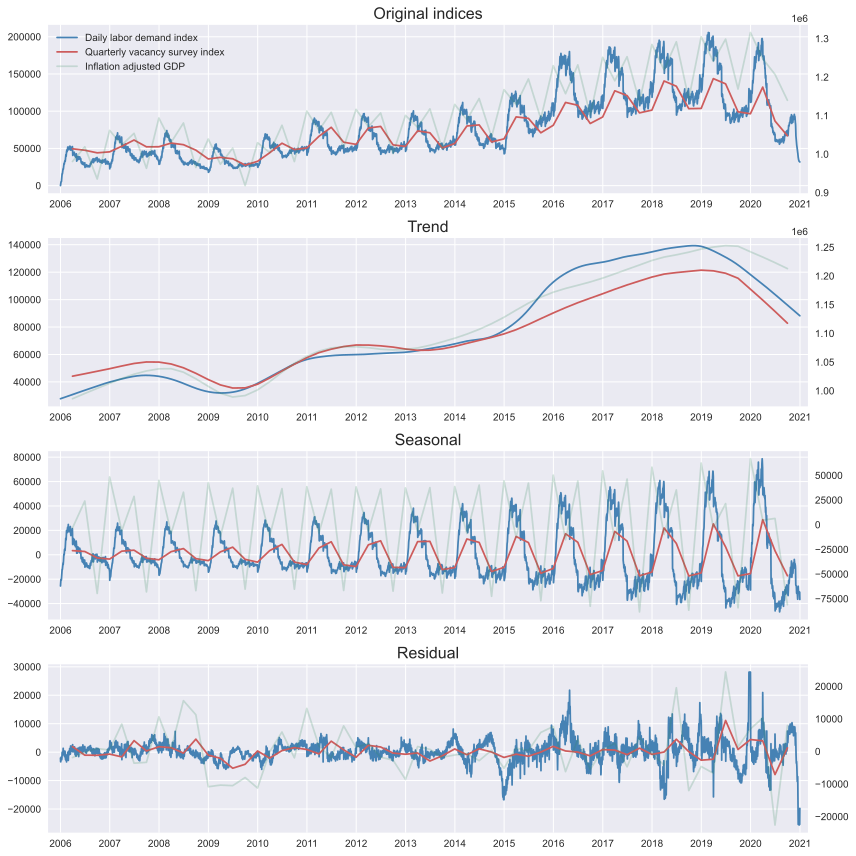

In [37]:
# Plotting each component of the indices together with constant-price GDP #
plt.figure(figsize=(12,12))
for plots, component in all_components.items():
    plt.subplot(4,1, plots[-1])
    x = plt.plot(component[0], label='Daily labor demand index', color='steelblue')
    y = plt.plot(component[1], label='Quarterly vacancy survey index', color='indianred')
    plt.title(plots[0], fontsize=16)
    plt.twinx()
    plt.xticks(ticks=date_index, labels=date_range)
    plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
    plt.grid(b=None)
    z = plt.plot(component[2], label='Inflation adjusted GDP', color='seagreen', alpha=0.2)
    if plots[-1] == 1:
        lines = x+y+z; labels = [i.get_label() for i in lines]
        plt.legend(lines, labels)
plt.tight_layout()

### 4.2 Regression analysis

In [13]:
# We use the mean job ads vacancies for each quarter #
results_resampled = results.resample('Q').mean().iloc[:-1,:]
results_trend_resampled = pd.DataFrame(res_trend.resample('Q').mean().iloc[:-1]).rename(columns={'trend':'ad_trend'})
results_season_resampled = pd.DataFrame(res_season.resample('Q').mean().iloc[:-1]).rename(columns={'season':'ad_season'})
results_resid_resampled = pd.DataFrame(res_resid.resample('Q').mean().iloc[:-1]).rename(columns={'resid':'ad_resid'})
res_comp = results_resampled.join(comparison).rename(columns={'Total':'survey_vacancies'})
res_comp_trend = results_trend_resampled.join(comp_trend).rename(columns={'trend':'survey_trend'})
res_comp_season = results_season_resampled.join(comp_season).rename(columns={'season':'survey_season'})
res_comp_resid = results_resid_resampled.join(comp_resid).rename(columns={'resid':'survey_resid'})

In [31]:
# First and last three observations of indices and each component # Model prediction based on regressions below #
display(res_comp.iloc[[0, 1, -2, -1],:])
display(res_comp_trend.iloc[[0, 1, -2, -1],:])
display(res_comp_season.iloc[[0, 1, -2, -1],:])
display(res_comp_resid.iloc[[0, 1, -2, -1],:])

,ad_vacancies,survey_vacancies,model_prediction
date,,,
2006-03-31,36269.888889,49486,45740.599439
2006-06-30,36032.846154,47554,45575.747390
2020-06-30,113403.637363,86775,99383.485846
2020-09-30,62550.402174,67046,64017.457711


,ad_trend,survey_trend,model_prediction
date,,,
2006-03-31,29288.948490,44172.116861,40341.468181
2006-06-30,32384.443213,45943.977388,42525.096460
2020-06-30,107445.733538,91389.796193,95474.938360
2020-09-30,99839.017769,82792.891215,90108.998132


,ad_season,survey_season,model_prediction
date,,,
2006-03-31,7713.664299,3379.088619,4815.241876
2006-06-30,3052.452520,2669.218895,1895.057799
2020-06-30,8178.472989,3256.096264,5106.438029
2020-09-30,-37527.130647,-17243.002615,-23527.484286


,ad_resid,survey_resid,model_prediction
date,,,
2006-03-31,-732.723901,1934.794520,-268.468188
2006-06-30,595.950420,-1059.196282,417.454896
2020-06-30,-2220.569164,-7870.892457,-1036.562667
2020-09-30,238.515051,1496.111400,232.930241


In [26]:
# Function to plot model prediction together with survey vacancies #
def plots(df):
    plt.figure(figsize=(11,4))
    plt.plot(df.index, df.iloc[:,0], label=df.columns[0], color='steelblue', alpha=0.2)
    plt.plot(df.index, df.iloc[:,1], label=df.columns[-2], color='indianred')
    plt.plot(df.index, df.iloc[:,2], label=df.columns[-1], color='seagreen')
    plt.xticks(ticks=date_index, labels=date_range)
    plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:       survey_vacancies   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1259.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           1.50e-40
Time:                        17:53:53   Log-Likelihood:                -599.00
No. Observations:                  59   AIC:                             1202.
Df Residuals:                      57   BIC:                             1206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.052e+04   1737.275     11.810   

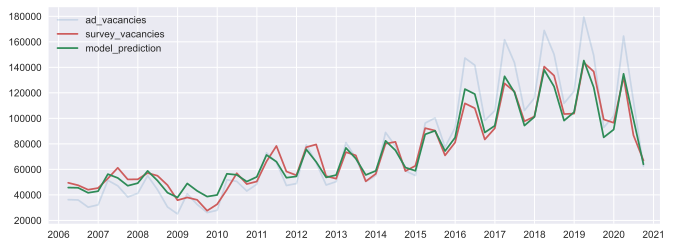

In [27]:
# Base model # survey_vacancies = beta0 + beta1 * ad_vacancies + e #
ols_base = sm.OLS(res_comp.iloc[:,1], sm.add_constant(res_comp.iloc[:,0])).fit()
res_comp['model_prediction'] = ols_base.predict()
print(ols_base.summary())
plots(res_comp)

                            OLS Regression Results                            
Dep. Variable:           survey_trend   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2621.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           2.37e-49
Time:                        17:53:53   Log-Likelihood:                -571.48
No. Observations:                  59   AIC:                             1147.
Df Residuals:                      57   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.968e+04   1190.780     16.527      0.0

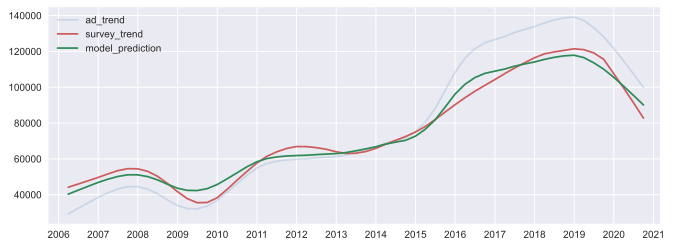

In [28]:
# Trend component # survey_trend = beta0 + beta1 * ad_trend + e #
ols_trend = sm.OLS(res_comp_trend.iloc[:,1], sm.add_constant(res_comp_trend.iloc[:,0])).fit()
res_comp_trend['model_prediction'] = ols_trend.predict()
print(ols_trend.summary())
plots(res_comp_trend)

                            OLS Regression Results                            
Dep. Variable:          survey_season   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     856.8
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           4.94e-36
Time:                        17:53:54   Log-Likelihood:                -554.84
No. Observations:                  59   AIC:                             1114.
Df Residuals:                      57   BIC:                             1118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.2611    389.028     -0.044      0.9

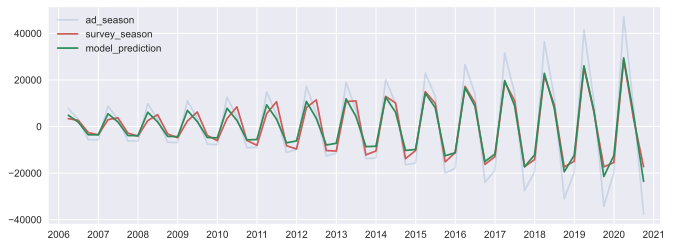

In [29]:
# Seasonal component # survey_season = beta0 + beta1 * ad_season + e #
ols_season = sm.OLS(res_comp_season.iloc[:,1], sm.add_constant(res_comp_season.iloc[:,0])).fit()
res_comp_season['model_prediction'] = ols_season.predict()
print(ols_season.summary())
plots(res_comp_season)

                            OLS Regression Results                            
Dep. Variable:           survey_resid   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     13.00
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           0.000657
Time:                        17:53:54   Log-Likelihood:                -544.14
No. Observations:                  59   AIC:                             1092.
Df Residuals:                      57   BIC:                             1096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.7977    325.606      0.337      0.7

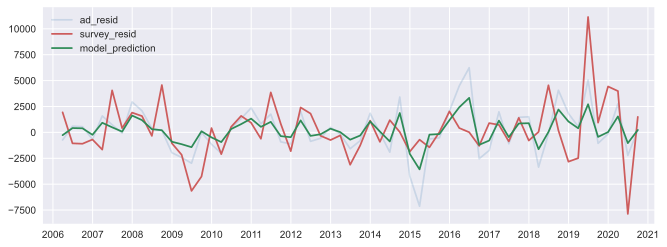

In [30]:
# Residual component # survey_residual = beta0 + beta1 * ad_residual + e #
ols_resid = sm.OLS(res_comp_resid.iloc[:,1], sm.add_constant(res_comp_resid.iloc[:,0])).fit()
res_comp_resid['model_prediction'] = ols_resid.predict()
print(ols_resid.summary())
plots(res_comp_resid)

### 4.3 Postestimation tests: Engel-Granger test (i.e. unit-root and co-integration test)

In [206]:
# Engel-Granger test #
display(engle_granger(res_comp.iloc[:,1], res_comp.iloc[:,0]))

Test Statistic,-4.837
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),0.419


### Discussion of results
- In progress

<hr />

### Extensions:
- In addition to the main results presented in this notebook, some extensions will be done in separeate notebooks. The theses extensions we disaggregate our index by county/city and occupational group using [SSYK classification](https://www.scb.se/dokumentation/klassifikationer-och-standarder/standard-for-svensk-yrkesklassificering-ssyk/) (Swedens official classification system for occupational groups, only available in Swedish). You can find theses extension notebooks in the repo.
   - **Extension 1**: In the first extension we add data on job ad municipality. This is to investigate local changes in labor demand over time.
   - **Extension 2**: We add data on occupational group (SSYK level 4) to investigate changes in labor demand for different groups on the job market.
   - **Extension 3**: We combine above two extensions to investigate changes in local and occupational labor demand.
- (Why don't you do extension 3 right away?) - There is a higher frequency of missing data on municipality and occupational group. Thus, combining the requirements of both municipality and occupational group not being null, a large amout of ads will be filtered out. This is why the extensions are done step-wise.

<hr />

### Concluding remarks
#### Thank you for examining my project! Pleas contact me if you have any feedback on possible improvement or other comments on the project.

Contact: [kevin.dee.boman@gmail.com](kevin.dee.boman@gmail.com)